## **pip Install Packages**

In [37]:
!pip install yfinance
!pip install nsetools
!pip install nsetools --upgrade

## **Import all the required Libraries**

In [38]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import datetime as dt

## **Implementataion on Different Market Index**
Here we have used three indices - NIFTY50, S&P500 and SHANGHAI50 to test our strategies

                          

In [39]:
indices = ['^NSEI', '000001.SS','^GSPC']

# ^NSEI - NIFTY50
# ^GSPC - S&P500
# 000001.SS - SSE COMPOSITE INDEX

## **Download Market Indices Data**
Download using the 'yfinance' library for all the indices we use.

In [43]:
def download_data(index1):
    # name of the index (key) - index values (value)
    index_data = {}


    for index in index1:
        # closing prices
        ticker = yf.Ticker(index)
        index_data['Close'] = ticker.history(period = '10y')['Close']

    return pd.DataFrame(index_data)

# Show the data on graph
def show_data(data):
    data.plot(figsize=(16, 6))
    plt.show()

# **MACD (Moving Average Convergence Divergence)**

Moving average convergence/divergence (MACD, or MAC-D) is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of a security’s price.

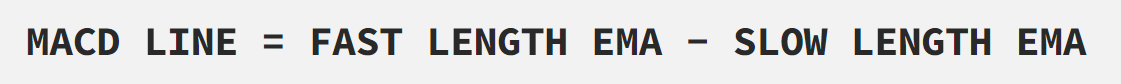

We use the standard slow length - 12 days and fast length - 26 days

## **Calculating MACD and SIGNAL lines**

In [44]:
def macd(dmacd):
    ## Calculate the Short Term Exponential Moving Average
    dmacd['ShortEMA']=dmacd['Close'].ewm(span=12, adjust=False).mean()
    ## Calculate the Long Term Exponential Moving Average
    dmacd['LongEMA']= dmacd['Close'].ewm(span=26, adjust=False).mean()
    ## Calculate the Moving Average Convergence/Divergence (MACD)
    dmacd['MACD'] = dmacd['ShortEMA'] - dmacd['LongEMA']
    ## Calcualte the signal line
    dmacd['signal'] = dmacd['MACD'].ewm(span=9, adjust=False).mean()
    dmacd['hist']= dmacd['MACD'] - dmacd['signal']
    return dmacd

def show_macd(df1, idx_name):
    fig, axs = plt.subplots(2, sharex=True, figsize=(20,15))
    fig.suptitle(idx_name,fontweight="bold")
    axs[0].plot(df1['Close'],label='Close')
    axs[0].legend(loc='upper left')
    axs[0].grid()
    axs[1].plot(df1['MACD'], label='MACD', color = 'blue')
    axs[1].plot(df1['signal'], label='Signal Line', color = 'Red')
    axs[1].plot(df1['hist'], label='MACD_hist' ,linestyle='--')

    axs[1].legend(loc='upper left')
    axs[1].grid()

## **MACD STRATEGY**
We use a simple strategy to get buy and sell signals using the MACD indicator.

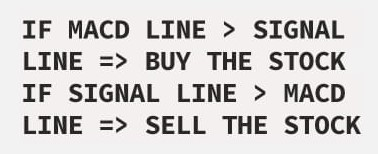

## **Calculating returns using the MACD strategy**

In [45]:
def find_returns_macd(dataset, index):
  #Generating Buy and Sell signals using the MACD strategy
  buy=[]
  sell=[]
  position = False

  for i in range(len(dataset)):
        if dataset.MACD[i]>dataset.signal[i]:
            if position == False:
                buy.append(i)
                position = True
        elif dataset.MACD[i]<dataset.signal[i]:
            if position == True:
                sell.append(i)
                position = False

  #Calculating the Returns from the Buy and Sell signals generated
  merged= pd.concat([dataset.iloc[buy].Close , dataset.iloc[sell].Close] , axis=1)
  merged.columns = ['Buy', 'Sell']
  totalprofit = merged.shift(-1).Sell-merged.Buy
  percent_profits = (merged.shift(-1).Sell-merged.Buy) / merged.Buy

  #Printing the Calculated Returns
  str_1 = "The return of "
  str_2 = " is "
  print(str_1,index,str_2,percent_profits.sum(), sep=" ")

## **MACD Plots & Returns**

The return of  ^NSEI  is  0.6933524969270779
The return of  000001.SS  is  0.8176335537539188
The return of  ^GSPC  is  0.5657112777175491


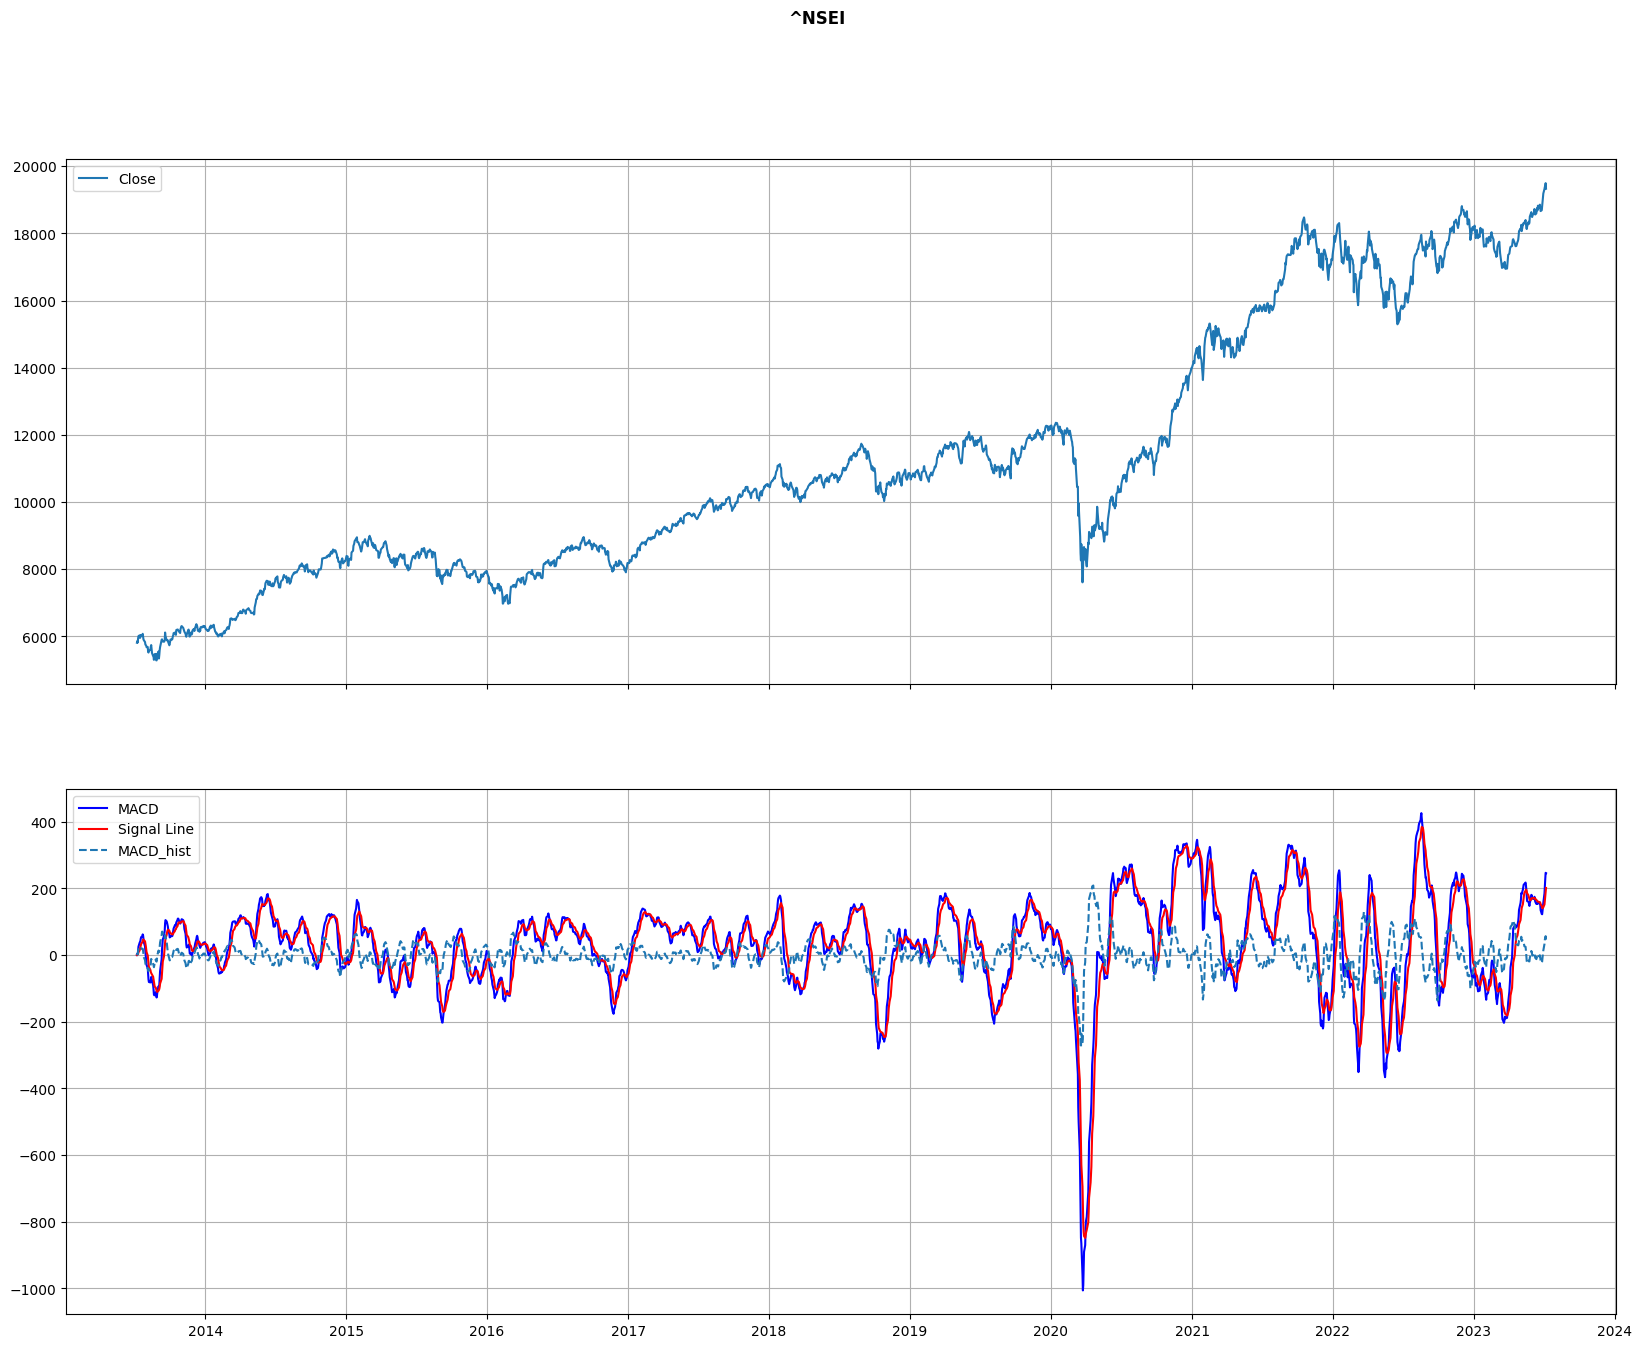

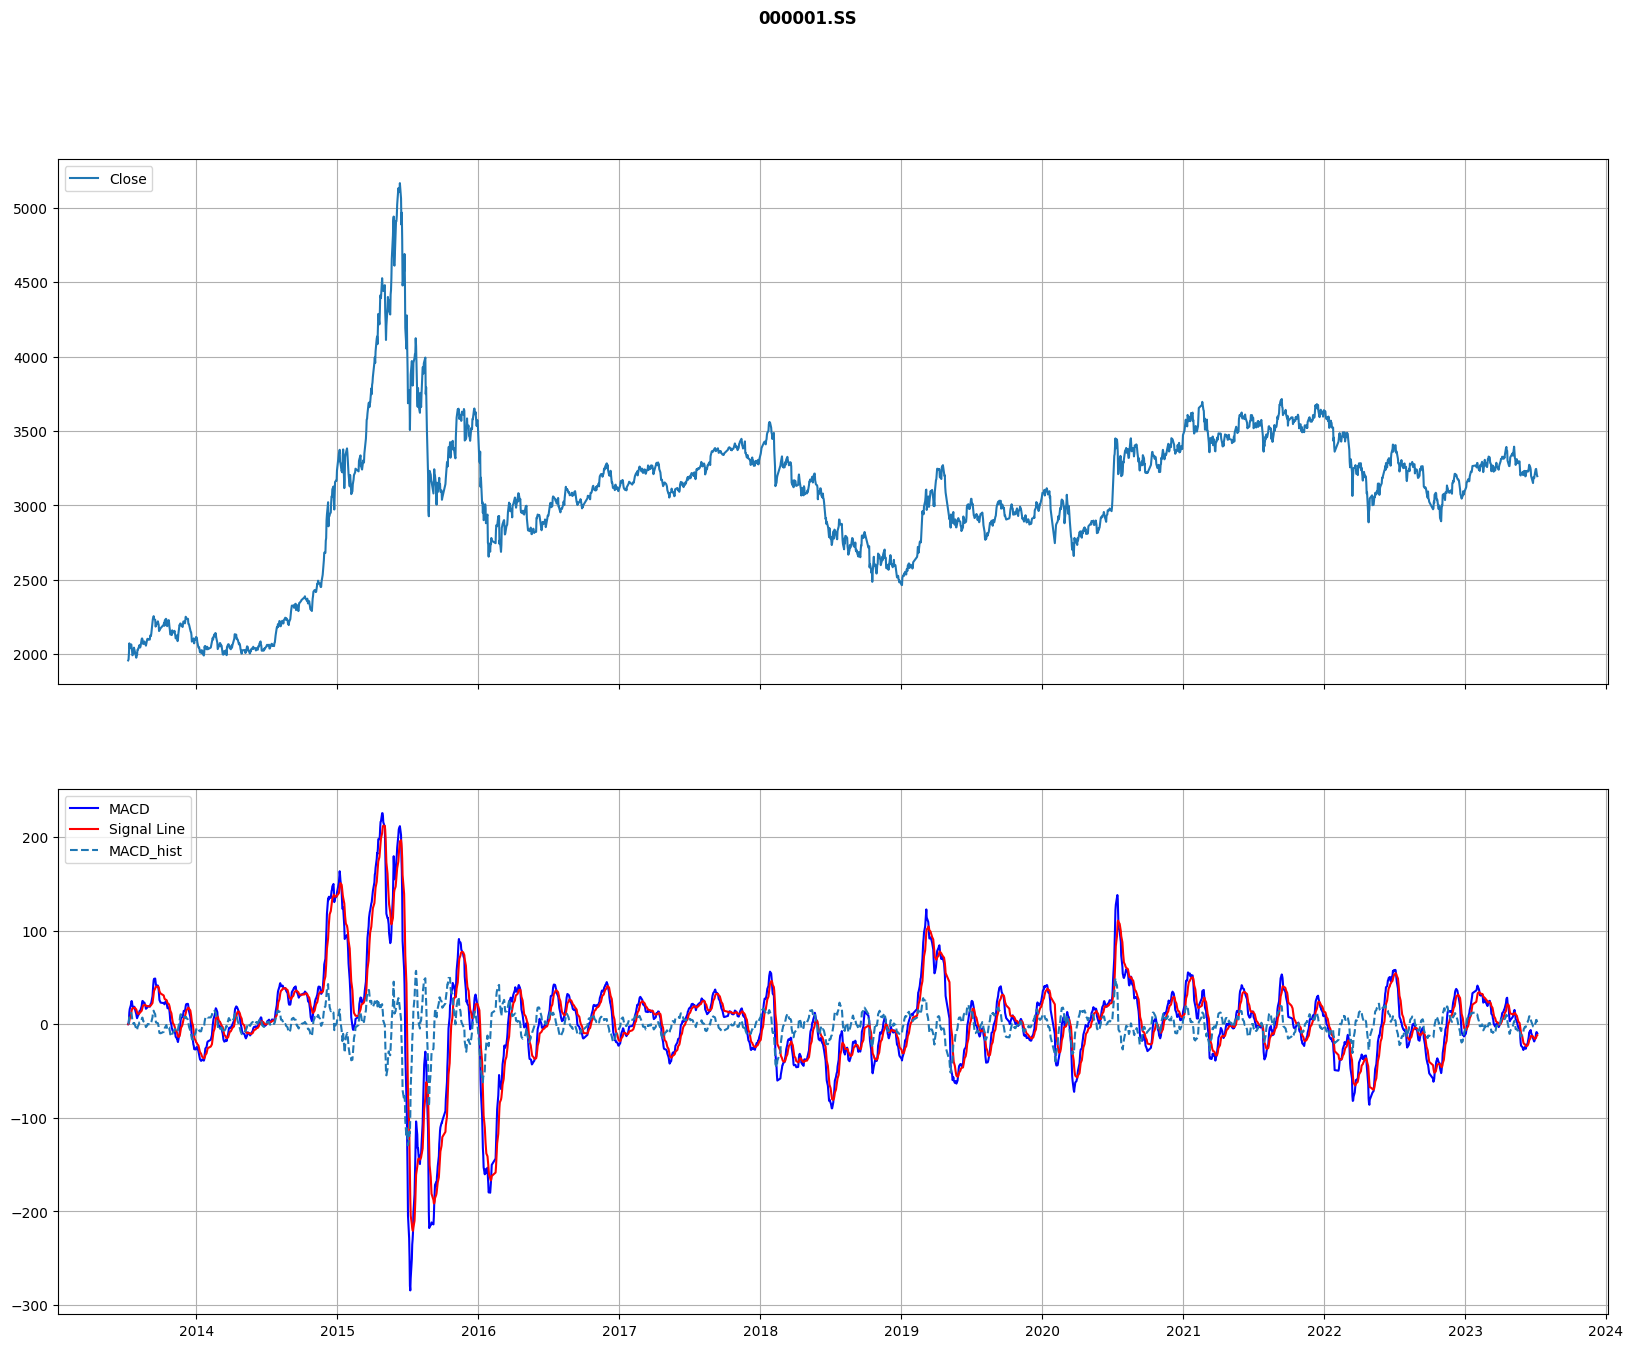

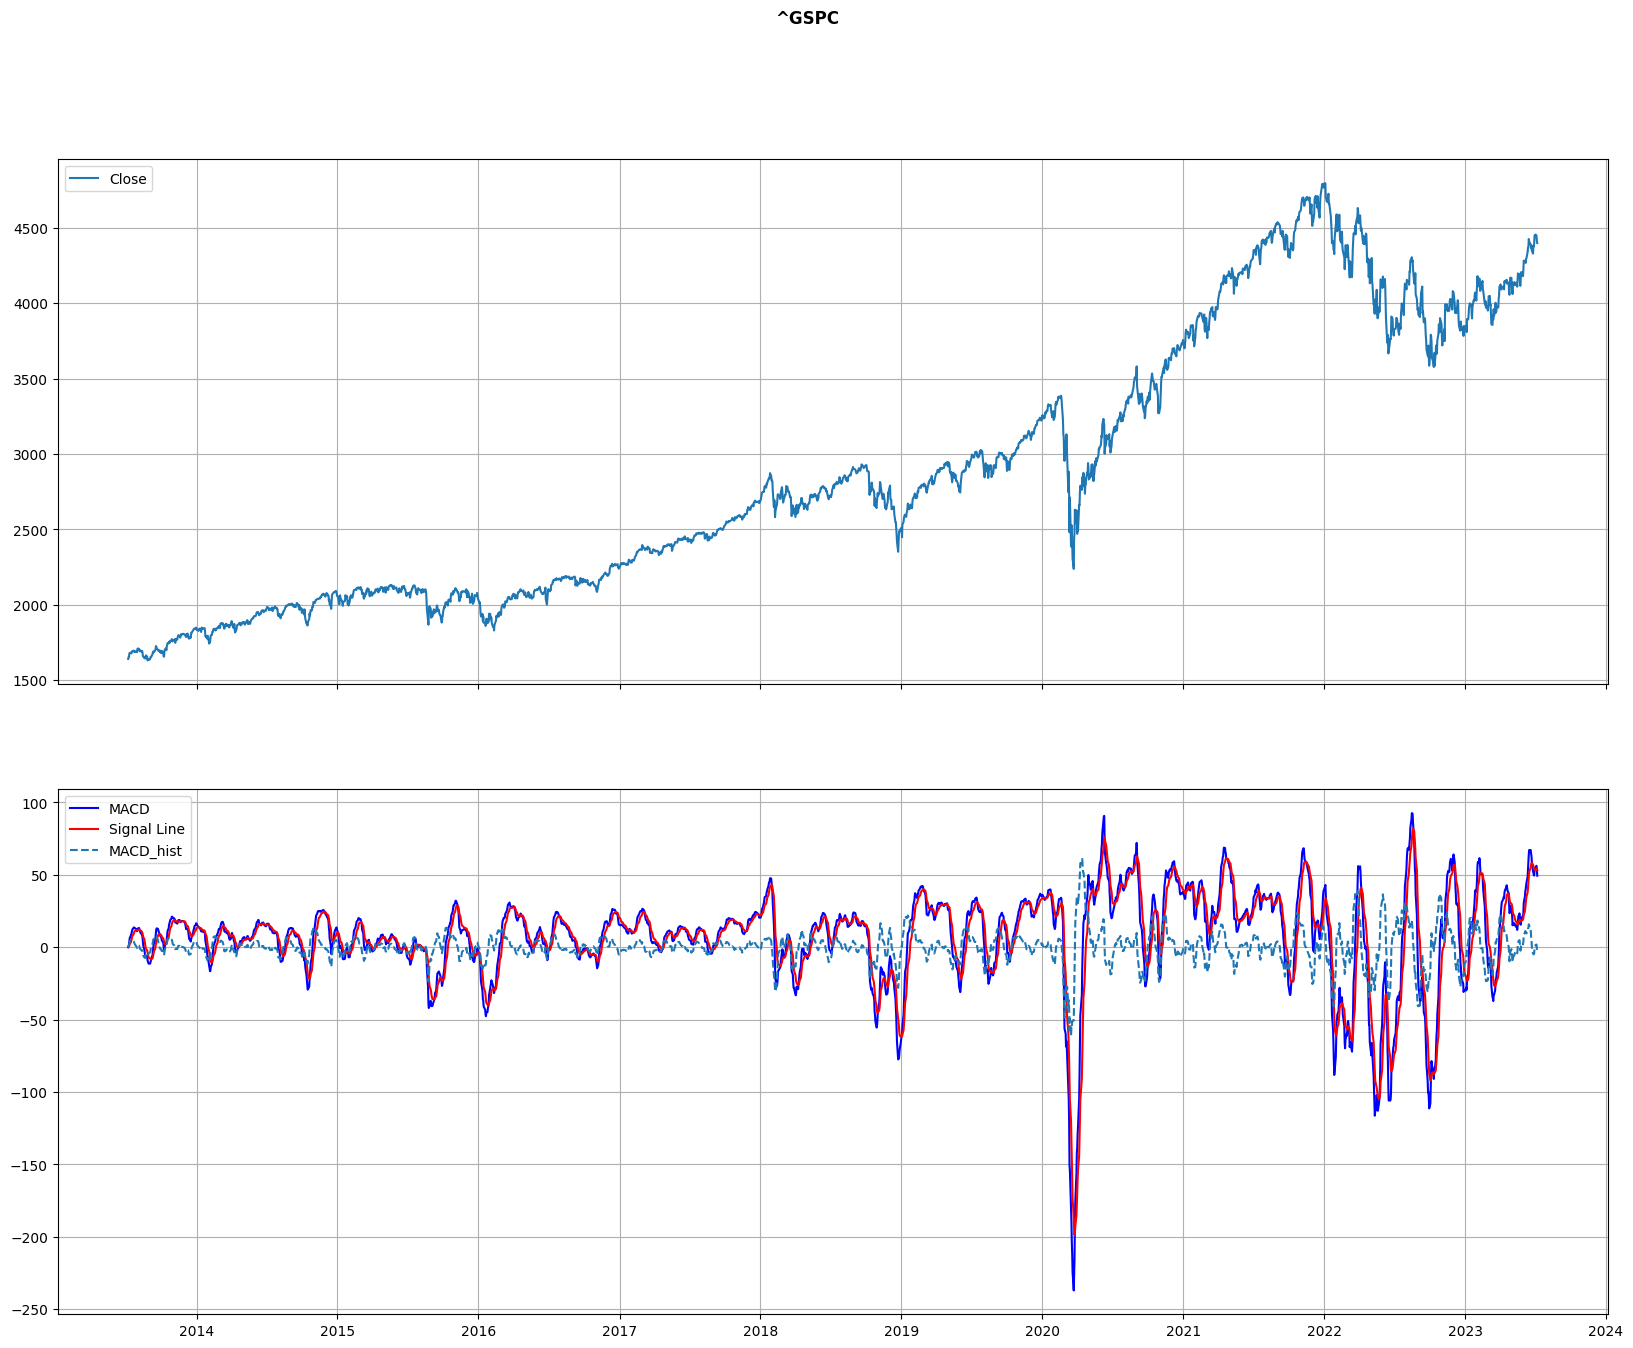

In [46]:
i = 0
for indeX in indices:
  x = [indices[i]]
  dataset1 = download_data(x)
  macD = macd(dataset1)
  show_macd(macD, indices[i])
  find_returns_macd(dataset1, indices[i])
  i=i+1

# **Bollinger Bands**

These are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity, using a formulaic method which display a graphical band (the envelope maximum and minimum of moving averages) and volatility (expressed by the width of the envelope) in one two-dimensional chart.



## **Calculating the Bollinger Bands**
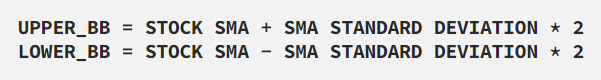

In [47]:
def bb(db):
    db['SMA']=np.nan
    db['STD']=np.nan
    db['BU']=np.nan
    db['BL']=np.nan
    for x in range(15,len(db)):
        db['SMA'][x]=db['Close'][(x-14):x].mean()
        db['STD'][x]=db['Close'][(x-14):x].std()
        db['BU'][x]=(db['SMA'][x]+db['STD'][x]*2)
        db['BL'][x]=(db['SMA'][x]-db['STD'][x]*2)
    return db

def show_bb(df1, idx_name):
    fig, axs = plt.subplots(2, sharex=True, figsize=(20,15))
    fig.suptitle(idx_name,fontweight="bold")
    axs[0].plot(df1['Close'],label='Close')
    axs[0].legend(loc='upper left')
    axs[0].grid()
    axs[1].plot(df1['Close'],label='Close')
    axs[1].plot(df1['BU'],label='Upper Band')
    axs[1].plot(df1['BL'],label='Lower Band')
    axs[1].legend(loc='upper left')
    axs[1].grid()
    plt.fill_between (df1.index, df1.BU,df1.BL, color ='grey', alpha = 0.3)


## **B-BANDS Strategy**
We use a simple strategy to get buy and sell signals from the B-Bands indicator.

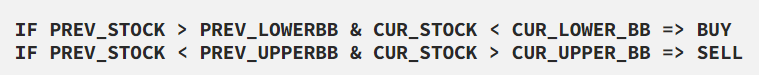

## **Calculating returns using the B-BANDS strategy**

In [48]:
def find_returns_bb(dataset, index):
  buy=[]
  sell=[]
  open_pos = False

  for i in range(len(dataset)):
      if open_pos == False:
       if dataset.BL[i-1] > dataset.Close[i-1]:
         if dataset.BL[i] < dataset.Close[i]:
            buy.append(i)
            open_pos= True
      elif open_pos == True:
        if dataset.BU[i-1] < dataset.Close[i-1]:
          if dataset.BU[i] > dataset.Close[i]:
            sell.append(i)
            open_pos = False


  merged= pd.concat([dataset.iloc[buy].Close , dataset.iloc[sell].Close] , axis=1)
  merged.columns = ['Buy', 'Sell']
  totalprofit = merged.shift(-1).Sell-merged.Buy
  percent_profits = (merged.shift(-1).Sell-merged.Buy) / merged.Buy

  str_1 = "The return of "
  str_2 = " is "
  print(str_1,index,str_2,percent_profits.sum(), sep=" ")

## **B-BANDS Plots & Returns**

The return of  ^NSEI  is  0.6123330334176578
The return of  000001.SS  is  0.12493698150582608
The return of  ^GSPC  is  0.9748426095274292


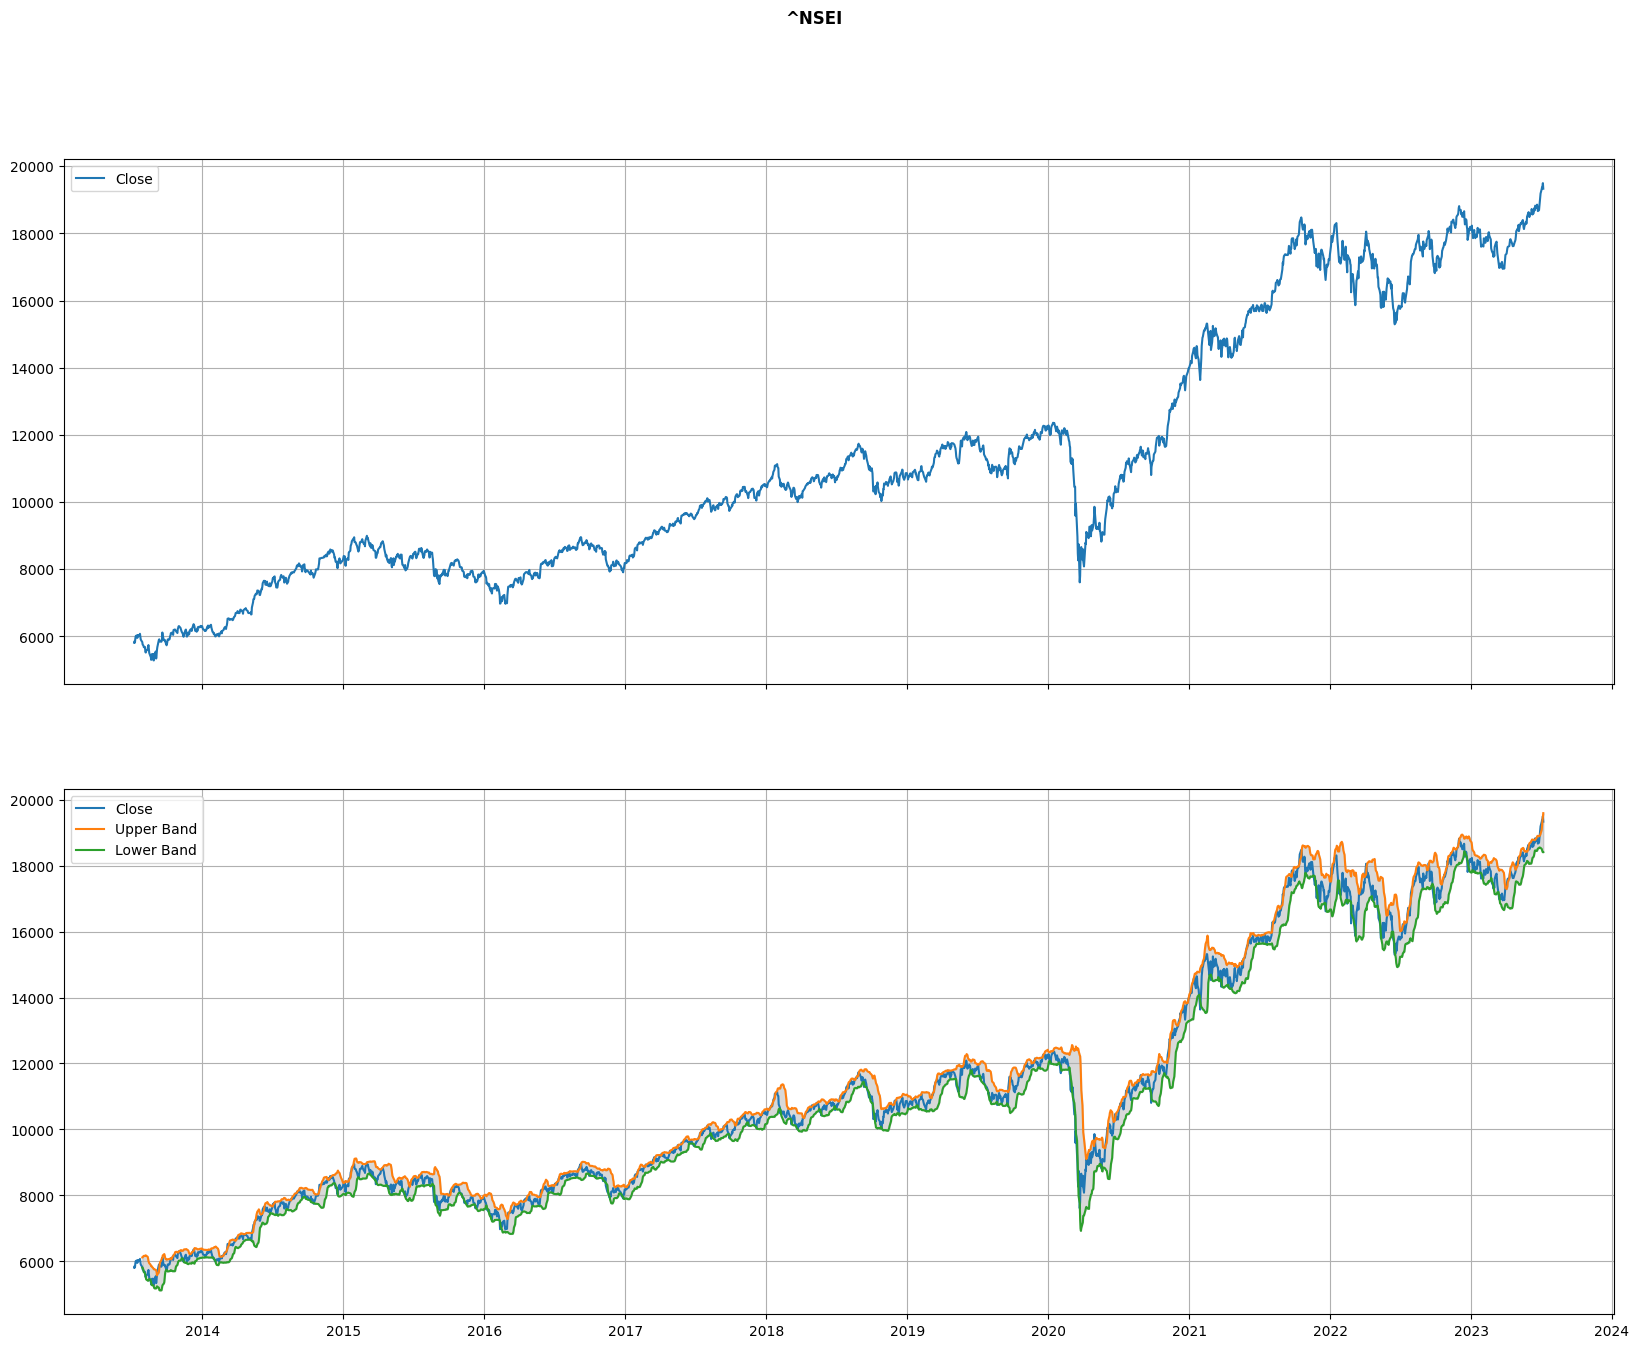

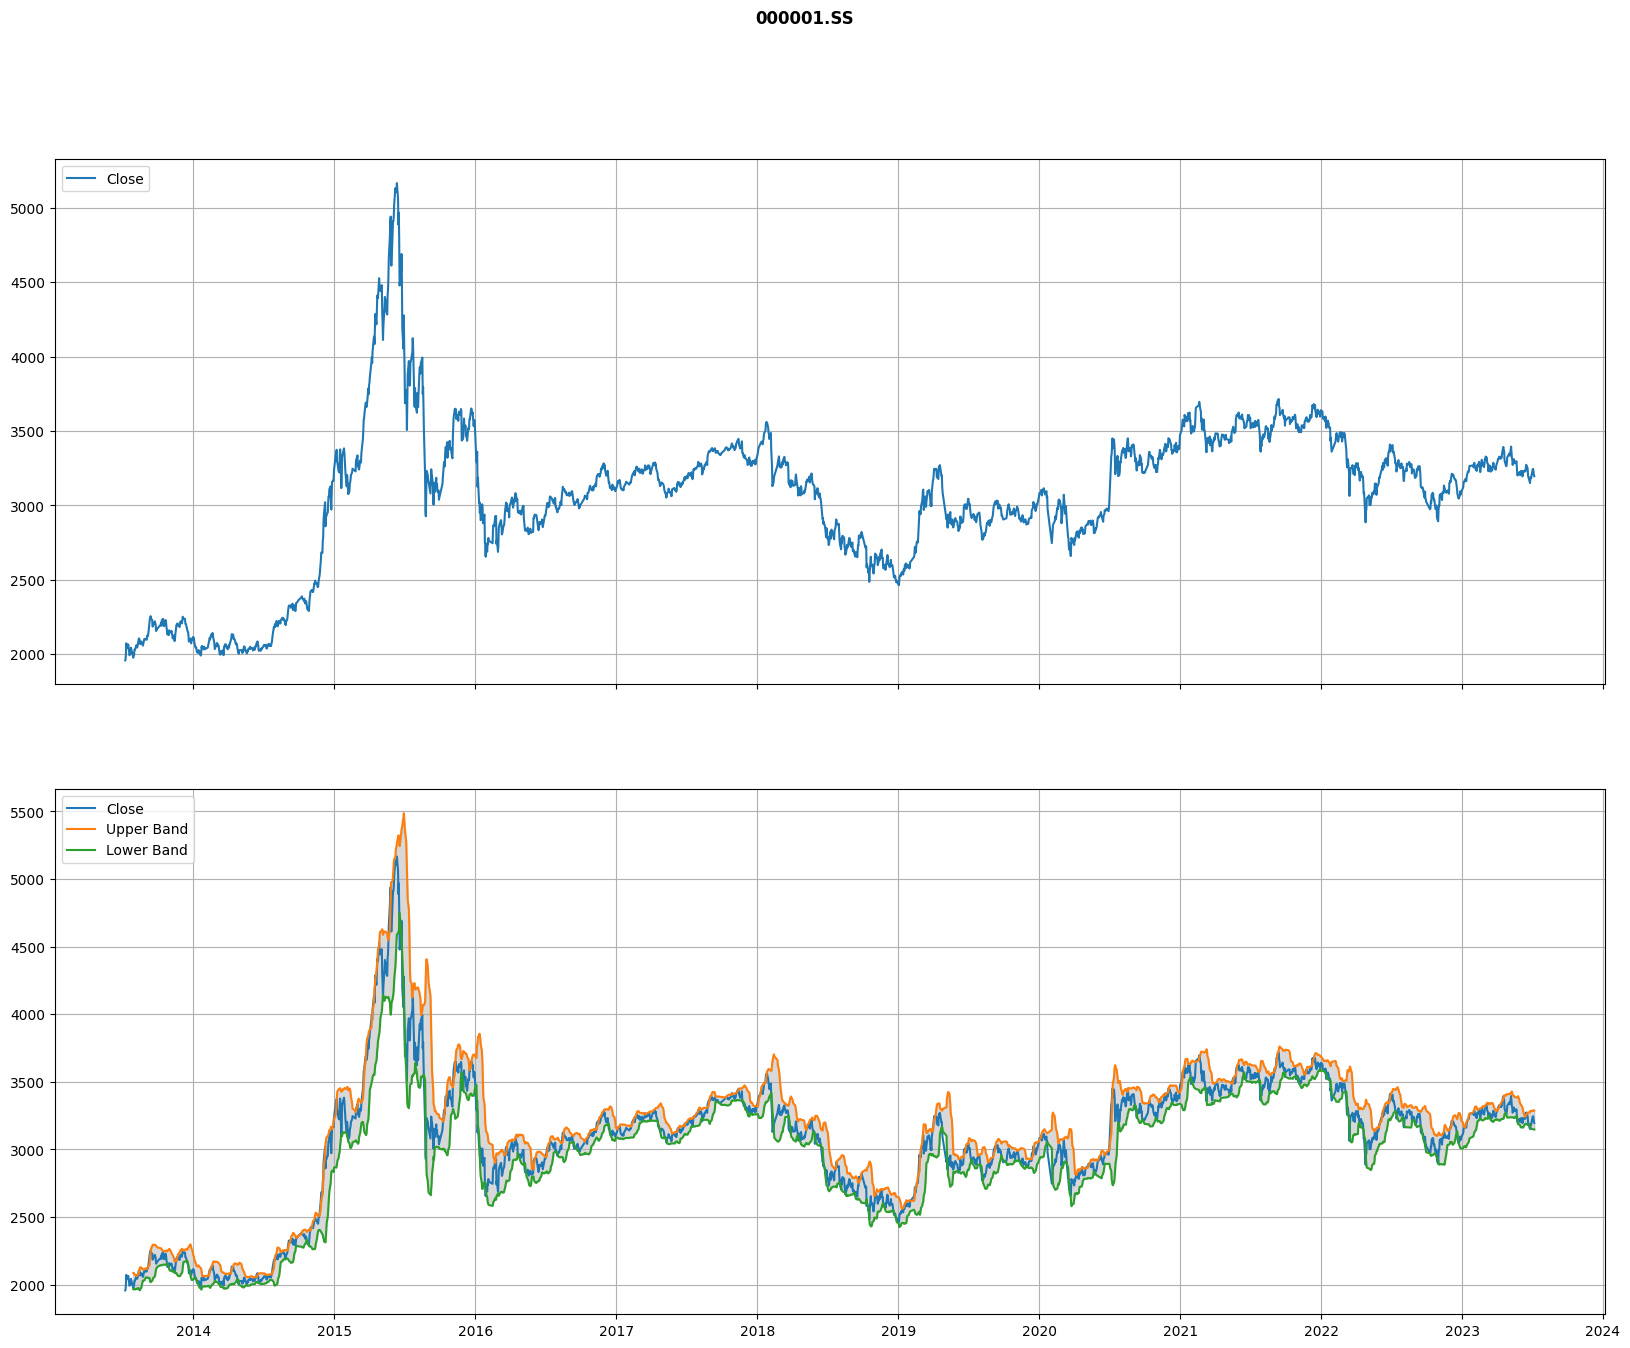

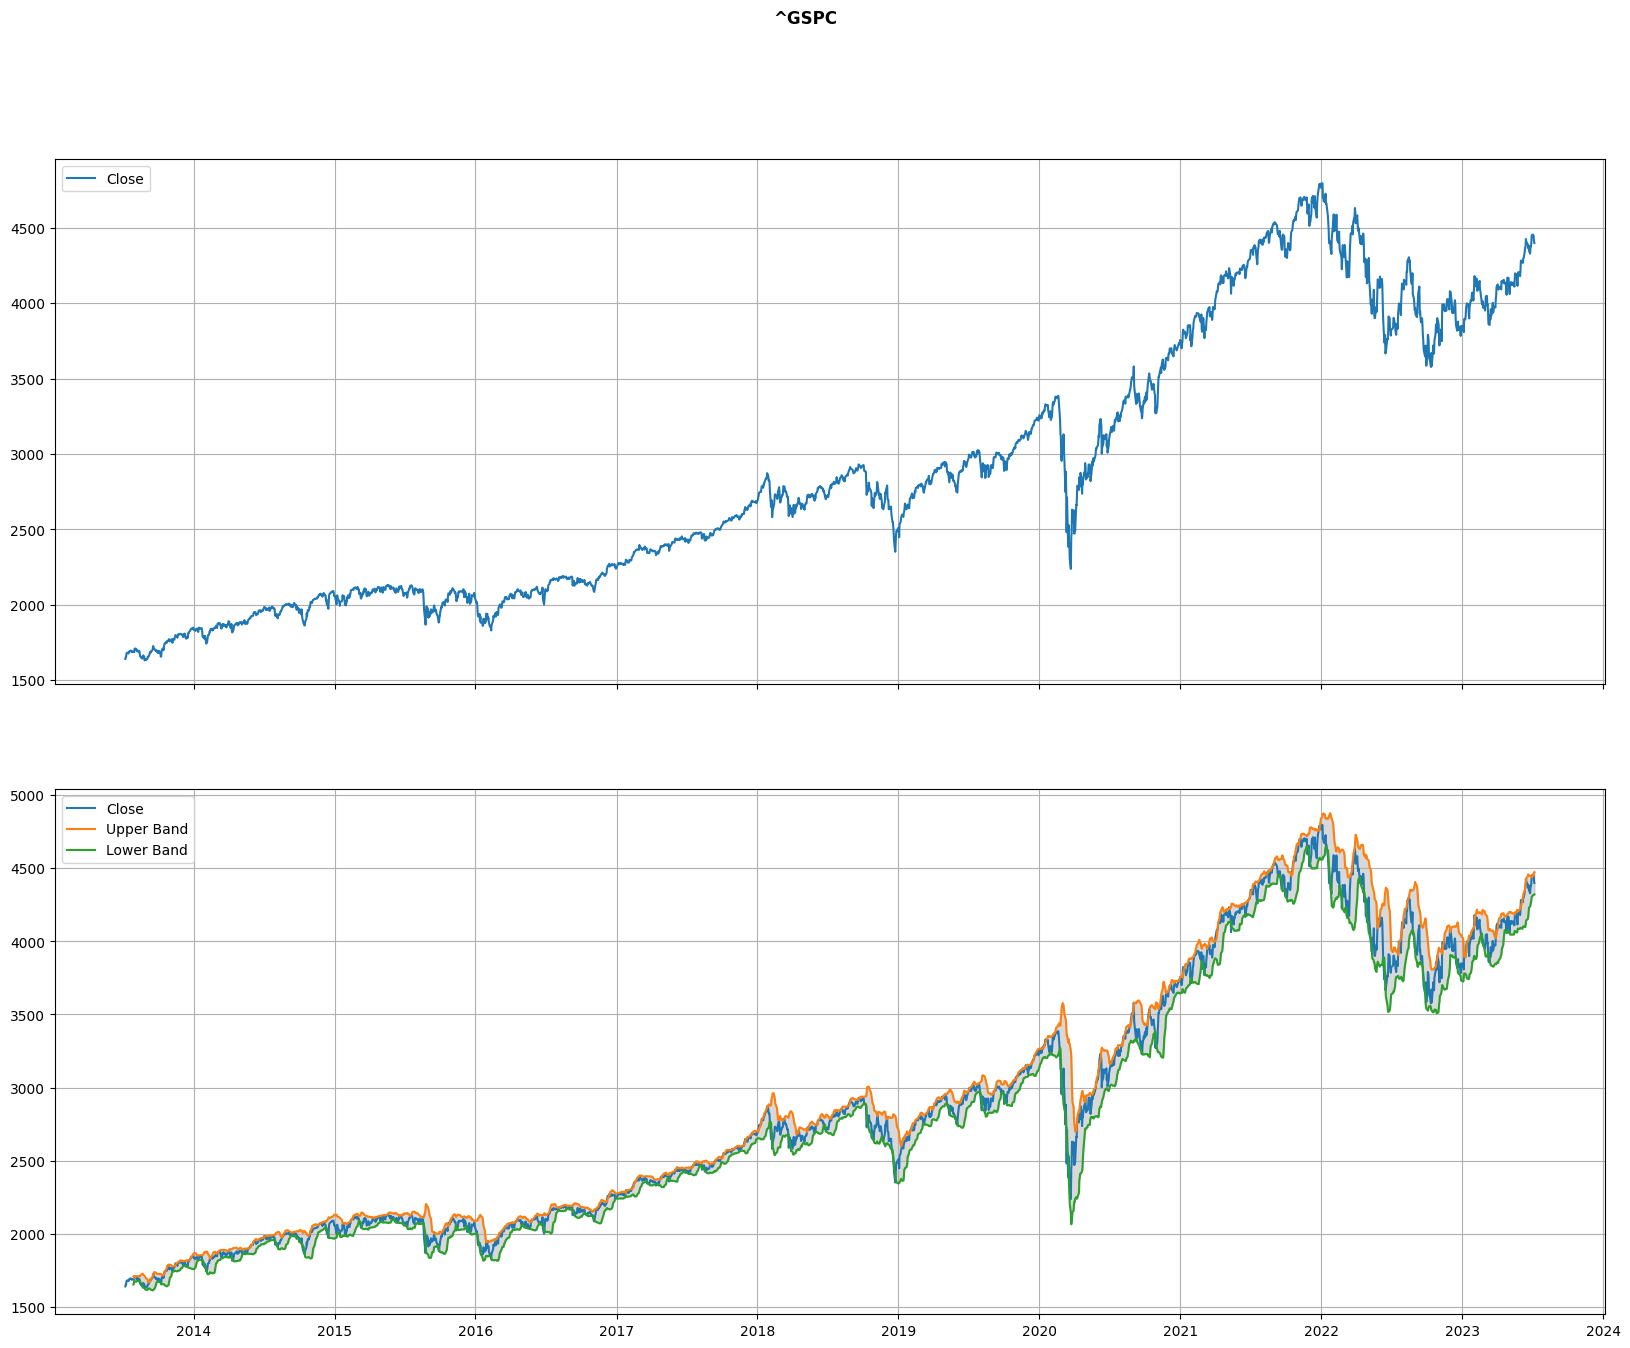

In [49]:
i = 0
for indeX in indices:
  x = [indices[i]]
  dataset2 = download_data(x)
  bB = bb(dataset2)
  show_bb(bB, indices[i])
  find_returns_bb(dataset2, indices[i])
  i=i+1

## **MIXED STRATEGY**
Here we have used both the indicators we saw above and used them simultaneously to make a mixed strategy. The strategy implemented in this code buys when the closing price of the asset is above the middle line of the Bollinger Bands, and the MACD is above the signal line. It gives a sell signal using the same B-Bands strategy we used above. We then evaluate the performance of the strategy by calculating the profits. The total profit is calculated by subtracting the closing price at the sell signal from the closing price at the buy signal and the percentage profit by dividing the total profit by the closing price at the buy signal.


In [50]:
#dataset1 - MACD dataset
#dataset2 - BB dataset

def mixed_strategy(dataset1, dataset2, index):
  # Create empty lists to store buy and sell signals
  buy = []
  sell = []

  # Create a flag to track whether a position is currently open
  open_pos = False

  # Loop through the data in dataset2
  for i in range(len(dataset2)):
    # Check if a position is currently open
    if open_pos == False:
      # If the closing price is above the middle line of the Bollinger Bands
      # and the MACD is above the signal line, then generate a buy signal
      if dataset2.Close[i] > (dataset2.BU[i] + dataset2.BL[i]) / 2:
        if dataset1.MACD[i] > dataset1.signal[i]:
          buy.append(i)
          # Set the open_pos flag to True to indicate that a position is now open
          open_pos = True
    # If a position is currently open
    elif open_pos == True:
      # If the upper line of the Bollinger Bands is crossed downwards and
      # the closing price is below the middle line, then generate a sell signal
      if dataset2.BU[i - 1] < dataset2.Close[i - 1]:
        if dataset2.BU[i] > dataset2.Close[i]:
          sell.append(i)
          # Set the open_pos flag to False to indicate that the position is now closed
          open_pos = False

  # Concatenate the closing prices at the buy and sell signal indices from dataset1
  merged = pd.concat([dataset1.iloc[buy].Close, dataset1.iloc[sell].Close], axis=1)

  # Set the column names of the DataFrame to 'Buy' and 'Sell'
  merged.columns = ['Buy', 'Sell']

  # Calculate the total profit by subtracting the closing price at the sell signal
  # from the closing price at the buy signal, and shifting the sell signal down by one
  totalprofit = merged.shift(-1).Sell - merged.Buy

  # Calculate the percentage profit by dividing the total profit by the closing price at the buy signal
  percent_profits = (merged.shift(-1).Sell - merged.Buy) / merged.Buy

  str_1 = "The return of "
  str_2 = " is "
  print(str_1,index,str_2,percent_profits.sum(), sep=" ")

In [51]:
# Initialize a counter variable to keep track of the current index
i = 0

# Loop through the indices
for index in indices:
  # Download the dataset for the current index
  x = [indices[i]]
  dataset1 = download_data(x)

  # Calculate the MACD for the dataset
  macD = macd(dataset1)

  # Download the dataset for the current index again
  dataset2 = download_data(x)

  # Calculate the Bollinger Bands for the dataset
  bB = bb(dataset2)

  # Generate buy and sell signals for the current index using the mixed_strategy function
  mixed_strategy(dataset1, dataset2, indices[i])

  # Increment the counter variable
  i = i + 1

The return of  ^NSEI  is  1.1946157765099903
The return of  000001.SS  is  0.5384244691569714
The return of  ^GSPC  is  1.1116230054309808
